In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [4]:
import pandas as pd # 파일입력, 교차표, 원핫인코딩
import numpy as np
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model # 모델
from tensorflow.keras.layers import Dense, Input, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터 분리

# 이진분류(로지스틱 회귀분석)
- 1. 데이터셋 생성 & 전처리
    * 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리
      -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리
- 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 혼동행렬==교차표)
- 4. 모델 사용

### 컬럼명   의미 및 설명
```
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
```

## 1. 데이터셋 생성 & 전처리
엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리 -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리

In [5]:
# 아나콘다 프롬프트에서 ml-dl-nlp가상환경(conda activate ml-dl-nlp)으로 간 후
# pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx', 
                   sheet_name='processed.cleveland'
                  )
df.info()
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [6]:
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [7]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [8]:
# ?를 결측치(np.nan)로 대체 -> 결측치 처리(삭제)
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [9]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [10]:
# 결측치 처리:대체(fillna), 삭제(dropna)
df = df.dropna(how='any') # 결측치가 한열이라도 있으면 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [11]:
df.shape, len(df)

((296, 14), 296)

In [12]:
# target변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() / df.shape[0] *100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [13]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리
X = df.iloc[:, :-1].values # 맨마지막열을 제외한 부분을 numpy 배열
y = df.iloc[:, -1:].values # 2차원 numpy 배열(train_test_split 사용)
X.shape, y.shape

((296, 13), (296, 1))

In [14]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [15]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [16]:
# scaled_X, y를 학습셋:테스트셋 = 7:3으로 분할
x_train, x_test, y_train, y_test = train_test_split(scaled_X,
                                            y,
                                            test_size=0.3, # 테스셋이 비율
                                            random_state=7,
                                            stratify=y) # 층화추출

In [17]:
# 심장병 음성/양성의 비율
print(pd.DataFrame(y).value_counts(normalize=True) )
print(pd.DataFrame(y_train).value_counts(normalize=True) )
print(pd.DataFrame(y_test).value_counts(normalize=True) )

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 모델 : 13 -> 32 -> 16 -> 8 -> 1
- 그래프를 보고, 과적합 줄이기 추가할 수 있음

In [72]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                448       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                

In [73]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam', 
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()])   # 재현율(실제값 중심)

In [74]:
%%time
hist = model.fit(x_train, y_train, # 훈련데이터셋
                epochs=200,            #  학습횟수
                validation_split=0.2,  # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0) # 로그출력 안함

CPU times: total: 8.22 s
Wall time: 7.22 s


## 3. 모델평가(그래프, 평가, 교차표)

In [76]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3'])

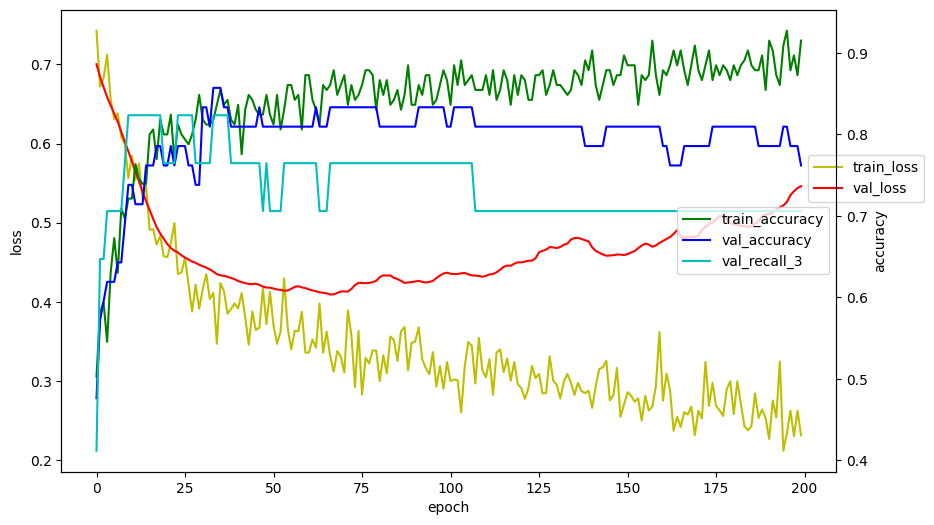

In [78]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_3'], 'c', label='val_recall_3')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [82]:
score = model.evaluate(x_test, y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model precision :', score[2])
print('model recall :', score[3])

model loss : 0.6895653605461121
model accuracy : 0.8202247023582458
model precision : 0.7906976938247681
model recall : 0.8292682766914368


In [84]:
# 교차표(혼동행렬)
y_test.reshape(-1) # 실제값

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0], dtype=int64)

In [88]:
y_hat = (model.predict(x_test)>0.5).astype(int).reshape(-1)
y_hat # 예측값

3/3 [==============================] - 0s 2ms/step


array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [89]:
pd.crosstab(y_test.reshape(-1), y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,39,9
1,7,34


In [90]:
confusion_matrix(y_test, y_hat)

array([[39,  9],
       [ 7, 34]], dtype=int64)

## 4. 모델 사용
- 저장/예측

In [92]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [97]:
model.save('model/07.h5')
data = [[63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6]]
input_data  = scaler.transform(data)
(model.predict([input_data]) > 0.5).astype(int)

1/1 [==============================] - 0s 16ms/step


array([[0]])

# 분류분석
- 1. 데이터셋 생성 & 전처리
    * x_train, y_train, x_test, y_test를 사용 -> y_train과 y_test 원핫인코딩
- 2. 모델생성 & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 교차표)
- 4. 모델 사용(저장, 예측)

## 1. 데이터셋 생성 & 전처리
x_train, y_train, x_test, y_test를 사용 -> y_train과 y_test 원핫인코딩

In [20]:
y_train[0] # 0 -> 1 0 / 1-> 0 1

array([0], dtype=int64)

In [23]:
Y_train = to_categorical(y_train)
Y_test  = to_categorical(y_test)
x_train.shape, x_test.shape, Y_train.shape, Y_test.shape

((207, 13), (89, 13), (207, 2), (89, 2))

## 2. 모델생성 & 학습과정 설정 & 학습

In [27]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                448       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='categorical_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam', 
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()])   # 재현율(실제값 중심)

In [29]:
%%time
hist = model.fit(x_train, Y_train, # 훈련데이터셋
                epochs=200,            #  학습횟수
                validation_split=0.2,  # 검증데이터를 훈련데이터의 20%로 사용
                verbose=2) # 로그출력 안함

Epoch 1/200
6/6 - 1s - loss: 0.7424 - accuracy: 0.4909 - precision_1: 0.4909 - recall_1: 0.4909 - val_loss: 0.6563 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 0.6190 - 771ms/epoch - 128ms/step
Epoch 2/200
6/6 - 0s - loss: 0.7322 - accuracy: 0.4545 - precision_1: 0.4545 - recall_1: 0.4545 - val_loss: 0.6428 - val_accuracy: 0.6190 - val_precision_1: 0.6190 - val_recall_1: 0.6190 - 32ms/epoch - 5ms/step
Epoch 3/200
6/6 - 0s - loss: 0.7008 - accuracy: 0.5758 - precision_1: 0.5758 - recall_1: 0.5758 - val_loss: 0.6362 - val_accuracy: 0.7857 - val_precision_1: 0.7857 - val_recall_1: 0.7857 - 35ms/epoch - 6ms/step
Epoch 4/200
6/6 - 0s - loss: 0.6949 - accuracy: 0.5152 - precision_1: 0.5152 - recall_1: 0.5152 - val_loss: 0.6333 - val_accuracy: 0.7619 - val_precision_1: 0.7619 - val_recall_1: 0.7619 - 36ms/epoch - 6ms/step
Epoch 5/200
6/6 - 0s - loss: 0.6790 - accuracy: 0.5697 - precision_1: 0.5697 - recall_1: 0.5697 - val_loss: 0.6290 - val_accuracy: 0.7381 - val_precision

Epoch 40/200
6/6 - 0s - loss: 0.4931 - accuracy: 0.7636 - precision_1: 0.7636 - recall_1: 0.7636 - val_loss: 0.4934 - val_accuracy: 0.7619 - val_precision_1: 0.7619 - val_recall_1: 0.7619 - 29ms/epoch - 5ms/step
Epoch 41/200
6/6 - 0s - loss: 0.4999 - accuracy: 0.7879 - precision_1: 0.7879 - recall_1: 0.7879 - val_loss: 0.4924 - val_accuracy: 0.7619 - val_precision_1: 0.7619 - val_recall_1: 0.7619 - 28ms/epoch - 5ms/step
Epoch 42/200
6/6 - 0s - loss: 0.4698 - accuracy: 0.8061 - precision_1: 0.8061 - recall_1: 0.8061 - val_loss: 0.4902 - val_accuracy: 0.7857 - val_precision_1: 0.7857 - val_recall_1: 0.7857 - 30ms/epoch - 5ms/step
Epoch 43/200
6/6 - 0s - loss: 0.5131 - accuracy: 0.8000 - precision_1: 0.8000 - recall_1: 0.8000 - val_loss: 0.4866 - val_accuracy: 0.7857 - val_precision_1: 0.7857 - val_recall_1: 0.7857 - 31ms/epoch - 5ms/step
Epoch 44/200
6/6 - 0s - loss: 0.5219 - accuracy: 0.7091 - precision_1: 0.7091 - recall_1: 0.7091 - val_loss: 0.4889 - val_accuracy: 0.7857 - val_precisi

Epoch 79/200
6/6 - 0s - loss: 0.3703 - accuracy: 0.8242 - precision_1: 0.8242 - recall_1: 0.8242 - val_loss: 0.4366 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - 31ms/epoch - 5ms/step
Epoch 80/200
6/6 - 0s - loss: 0.4032 - accuracy: 0.8182 - precision_1: 0.8182 - recall_1: 0.8182 - val_loss: 0.4382 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - 35ms/epoch - 6ms/step
Epoch 81/200
6/6 - 0s - loss: 0.4171 - accuracy: 0.8000 - precision_1: 0.8000 - recall_1: 0.8000 - val_loss: 0.4425 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - 33ms/epoch - 5ms/step
Epoch 82/200
6/6 - 0s - loss: 0.3966 - accuracy: 0.8182 - precision_1: 0.8182 - recall_1: 0.8182 - val_loss: 0.4457 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - 33ms/epoch - 5ms/step
Epoch 83/200
6/6 - 0s - loss: 0.4282 - accuracy: 0.8121 - precision_1: 0.8121 - recall_1: 0.8121 - val_loss: 0.4491 - val_accuracy: 0.8333 - val_precisi

Epoch 118/200
6/6 - 0s - loss: 0.3480 - accuracy: 0.8667 - precision_1: 0.8667 - recall_1: 0.8667 - val_loss: 0.4197 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 31ms/epoch - 5ms/step
Epoch 119/200
6/6 - 0s - loss: 0.3435 - accuracy: 0.8606 - precision_1: 0.8606 - recall_1: 0.8606 - val_loss: 0.4208 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 30ms/epoch - 5ms/step
Epoch 120/200
6/6 - 0s - loss: 0.3705 - accuracy: 0.8606 - precision_1: 0.8606 - recall_1: 0.8606 - val_loss: 0.4251 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 32ms/epoch - 5ms/step
Epoch 121/200
6/6 - 0s - loss: 0.3995 - accuracy: 0.8364 - precision_1: 0.8364 - recall_1: 0.8364 - val_loss: 0.4309 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - 30ms/epoch - 5ms/step
Epoch 122/200
6/6 - 0s - loss: 0.3707 - accuracy: 0.8424 - precision_1: 0.8424 - recall_1: 0.8424 - val_loss: 0.4360 - val_accuracy: 0.8333 - val_pr

Epoch 157/200
6/6 - 0s - loss: 0.3518 - accuracy: 0.8242 - precision_1: 0.8242 - recall_1: 0.8242 - val_loss: 0.4421 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 30ms/epoch - 5ms/step
Epoch 158/200
6/6 - 0s - loss: 0.3382 - accuracy: 0.8667 - precision_1: 0.8667 - recall_1: 0.8667 - val_loss: 0.4425 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 29ms/epoch - 5ms/step
Epoch 159/200
6/6 - 0s - loss: 0.3439 - accuracy: 0.8606 - precision_1: 0.8606 - recall_1: 0.8606 - val_loss: 0.4380 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 30ms/epoch - 5ms/step
Epoch 160/200
6/6 - 0s - loss: 0.3580 - accuracy: 0.8788 - precision_1: 0.8788 - recall_1: 0.8788 - val_loss: 0.4393 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 29ms/epoch - 5ms/step
Epoch 161/200
6/6 - 0s - loss: 0.3621 - accuracy: 0.8303 - precision_1: 0.8303 - recall_1: 0.8303 - val_loss: 0.4445 - val_accuracy: 0.8095 - val_pr

Epoch 196/200
6/6 - 0s - loss: 0.3497 - accuracy: 0.8424 - precision_1: 0.8424 - recall_1: 0.8424 - val_loss: 0.4531 - val_accuracy: 0.7619 - val_precision_1: 0.7619 - val_recall_1: 0.7619 - 34ms/epoch - 6ms/step
Epoch 197/200
6/6 - 0s - loss: 0.3234 - accuracy: 0.8606 - precision_1: 0.8606 - recall_1: 0.8606 - val_loss: 0.4370 - val_accuracy: 0.7619 - val_precision_1: 0.7619 - val_recall_1: 0.7619 - 33ms/epoch - 5ms/step
Epoch 198/200
6/6 - 0s - loss: 0.3339 - accuracy: 0.8788 - precision_1: 0.8788 - recall_1: 0.8788 - val_loss: 0.4288 - val_accuracy: 0.7857 - val_precision_1: 0.7857 - val_recall_1: 0.7857 - 32ms/epoch - 5ms/step
Epoch 199/200
6/6 - 0s - loss: 0.3573 - accuracy: 0.8485 - precision_1: 0.8485 - recall_1: 0.8485 - val_loss: 0.4204 - val_accuracy: 0.8095 - val_precision_1: 0.8095 - val_recall_1: 0.8095 - 30ms/epoch - 5ms/step
Epoch 200/200
6/6 - 0s - loss: 0.4087 - accuracy: 0.8606 - precision_1: 0.8606 - recall_1: 0.8606 - val_loss: 0.4148 - val_accuracy: 0.8095 - val_pr

## 3. 모델평가(그래프, 평가, 교차표)

In [111]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5'])

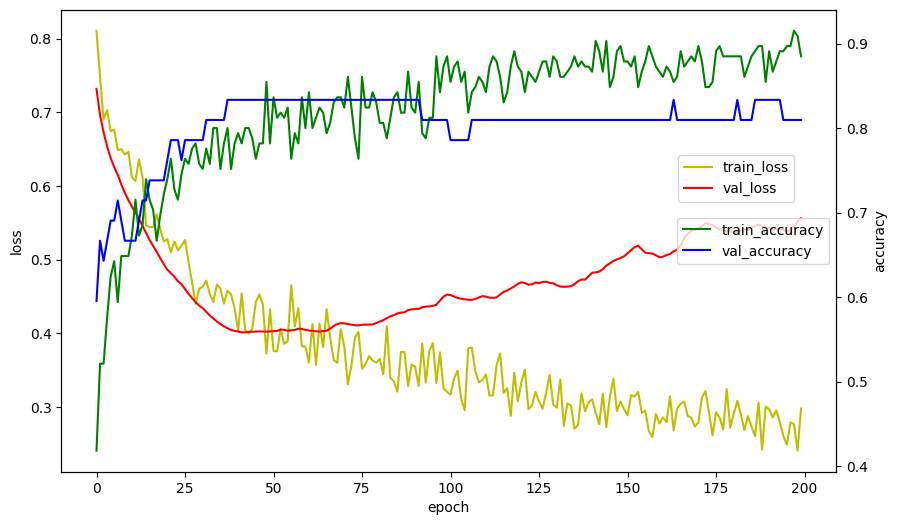

In [109]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [113]:
score = model.evaluate(x_test, Y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model precision :', score[2])
print('model recall :', score[3])

model loss : 0.6932504177093506
model accuracy : 0.8314606547355652
model precision : 0.8314606547355652
model recall : 0.8314606547355652


In [114]:
# 교차표(혼동행렬)
y_test.reshape(-1) # 실제값

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0], dtype=int64)

In [116]:
y_hat = model.predict(x_test).argmax(axis=1)
y_hat # 예측값

3/3 [==============================] - 0s 2ms/step


array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [117]:
pd.crosstab(y_test.reshape(-1), y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,40,8
1,7,34


In [118]:
confusion_matrix(y_test, y_hat)

array([[40,  8],
       [ 7, 34]], dtype=int64)

## 4. 모델 사용
- 저장/예측

In [125]:
data = [[63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6],
       [ 37, 1, 3, 130, 250, 0, 0, 187, 0, 3.5, 3, 0, 3]]
input_data  = scaler.transform(data)
model.predict([input_data], verbose=0).argmax(axis=1) # 둘다 심장병발병 음성 예측

array([0, 0], dtype=int64)

In [124]:
from tensorflow.keras.models import save_model, load_model
# model.save('model/07.h5')
# save_model(model, 'model/07.h5')
# model2 = load_model('model/07.h5')